# Анализ бизнес-показателей

Компания разрабатывает мобильное приложение.  
Несколько прошлых месяцев бизнес нес убытки.  
Нужно разобраться в причинах этой ситуации.

В распоряжении есть логи с данными о посещениях приложения новыми пользователями,  
зарегистрировавшимися в период с 2019-05-01 по 2019-10-27,  
выгрузка их покупок за этот период и статистика рекламных расходов.  
Нужно изучить, когда окупаются клиенты и какие факторы отрицательно влияют на привлечение пользователей.

**Описание данных**  
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Загрузка и подготовка данных
Оптимизация данные для анализа. Проверка типов данных.

In [1]:
#импорт библиотек
import pandas            as pd
import numpy             as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn           as sns
from scipy import stats  as st

import warnings
warnings.filterwarnings('ignore')

In [2]:
#чтение файлов с данными и сохранение в переменные
visits, orders, costs = (pd.read_csv('/datasets/visits_info_short.csv')   # журнал сессий
                         ,pd.read_csv('/datasets/orders_info_short.csv')  # покупки
                         ,pd.read_csv('/datasets/costs_info_short.csv'))  # траты на рекламу

In [3]:
#Функция выводит общую информацию о датафрейме:
# - первые 5 строк датафрейма,
# - инфо о количестве записей,       кол-ве столбцов и типе данных в них,
# - долю пропущенных значений в %,   кол-во явных дубликатов.
def data_info(df):
    display(df.head(3))
    df.info()
    print()
    print('\033[1m' + 'Доля пропусков в %:')
    display(pd.DataFrame(round((df.isna().mean() * 100),2)).style.background_gradient('coolwarm'))
    print('\033[1m' + 'Количество явных дубликатов:', df.duplicated().sum())

In [4]:
#посмотрим на общую информацию о каждом датафрейме   - инф о посещениях
data_info(visits)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB

Доля пропусков в %:


,0
User Id,0.000000
Region,0.000000
Device,0.000000
Channel,0.000000
Session Start,0.000000
Session End,0.000000


Количество явных дубликатов: 0


In [5]:
#инф-ция о заказах
data_info(orders)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB

Доля пропусков в %:


,0
User Id,0.000000
Event Dt,0.000000
Revenue,0.000000


Количество явных дубликатов: 0


In [6]:
#инф-ция о расходах на рекламу
data_info(costs)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB

Доля пропусков в %:


,0
dt,0.000000
Channel,0.000000
costs,0.000000


Количество явных дубликатов: 0


Приведем названия столбцов во всех датасетах к snake_case

In [7]:
dfs = {'visits':visits, 'orders':orders, 'costs':costs}
  
for (df_name, df) in dfs.items():
    print(df_name)
    df.columns = [x.lower().replace(' ', '_') for x in df.columns]
    print(df.columns)
    print()

visits
Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

orders
Index(['user_id', 'event_dt', 'revenue'], dtype='object')

costs
Index(['dt', 'channel', 'costs'], dtype='object')



In [8]:
#перевод данных о времени из строки в datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end']   = pd.to_datetime(visits['session_end'])
orders['event_dt']      = pd.to_datetime(orders['event_dt'])

costs['month']          = pd.to_datetime(costs['dt']).astype('datetime64[M]')

#costs['month_num'] = pd.to_datetime(costs['dt']).dt.month
costs['dt']             = pd.to_datetime(costs['dt']).dt.date

Исследуем уникальные значения в столбцах 'region', 'device', 'channel'

In [9]:
columns = ['region', 'device', 'channel']
for col in columns:
    print(col)
    print()
    print(visits[col].value_counts())
    print()
id_cnt_visits = visits['user_id'].nunique()
print('Количество уникальных пользователей в датасете \'visits\'', id_cnt_visits)

region

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

device

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

channel

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

Количество уникальных пользователей в датасете 'visits' 150008


In [10]:
#сократим названия рекламных каналов, чтобы все помещалось на экране
dfs = [costs, visits]
for df in dfs:
    df.loc[df['channel'] == 'WahooNetBanner',     'channel'] = 'Wahoo'
    df.loc[df['channel'] == 'lambdaMediaAds',     'channel'] = 'lambda'
    df.loc[df['channel'] == 'OppleCreativeMedia', 'channel'] = 'Opple'
    df.loc[df['channel'] == 'RocketSuperAds',     'channel'] = 'Rocket'
    df.loc[df['channel'] == 'MediaTornado',       'channel'] = 'Tornado'
    df.loc[df['channel'] == 'AdNonSense',         'channel'] = 'NonSense'
    
    print(df['channel'].value_counts())
    print()
visits.loc[visits['region'] == 'United States',   'region'] = 'USA'
print(visits['region'].value_counts())

Tornado     180
Rocket      180
NonSense    180
YRabbit     180
FaceBoom    180
Wahoo       180
lambda      180
LeapBob     180
Opple       180
TipTop      180
Name: channel, dtype: int64

organic     107760
TipTop       54794
FaceBoom     49022
Wahoo        20465
LeapBob      17013
Opple        16794
Rocket       12724
YRabbit       9053
Tornado       8878
NonSense      6891
lambda        6507
Name: channel, dtype: int64

USA        207327
UK          36419
France      35396
Germany     30759
Name: region, dtype: int64


**Вывод**  
Пропусков и явных дубликатов в данных нет.  
Столбцы user_id, revenue, costs содержат числовые данные - у них правильные типы, int64 и float64.   
Названия столбцов приведены к snake_case, значения столбцов с датами преобразованы в тип datetime.  
Датасеты содержат данные о четырех странах, четырех типах устройств и десяти рекламных каналах. 

## Функции для расчета и визуализации

### Функции для расчета и анализа  LTV, ROI, удержания, конверсии

In [11]:
#функция для расчёта удержания
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    dimensions = ['payer'] + dimensions      #добавляем payer в передаваемый dimensions список

    #исключаем users, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    #собираем сырые данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    #функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        cohort_sizes = df.groupby(dims).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)     #таб удержания

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days) #таб динамики удержания
    
    #возврат -сырые данные, таб удержания,  таб динамики удержания
    return result_raw,    result_grouped,   result_in_time

In [12]:
# функция для расчёта конверсии
def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    #исключаем users, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    #определяем дату и время первой покупки для каждого user
    first_purchases = (purchases.sort_values(by=['user_id', 'event_dt'])
                                .groupby('user_id').agg({'event_dt': 'first'}).reset_index())

    #добавляем данные о покупках в профили
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')

    #рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    #группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    #функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes =df.groupby(dims).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # делим каждую «ячейку» в строке на размер когорты - получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    #таб конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    #для таб динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    #таб динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    #возврат - сырые данные, таб конверсии,  таб динамики конверсии
    return result_raw,       result_grouped, result_in_time

In [13]:
#функция для расчёта LTV и ROI
def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    #исключаем users, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days-1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    #добавляем данные о покупках в профили
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id',how='left')
    #рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    #группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    #функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        #строим «треугольную» таблицу выручки
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        #находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        #вычисляем размеры когорт
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        #делим каждую «ячейку» в строке на размер когорты - получаем LTV
        result = result.div(result['cohort_size'], axis=0)
        #исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        #восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        #датафрейм с данными users и значениями CAC, добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        #считаем средний CAC по параметрам из dimensions
        cac = cac.groupby(dims).agg({'acquisition_cost':'mean'}).rename(columns={'acquisition_cost':'cac'})

        #считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        #удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        #восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        #добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        #оставляем размеры когорт, CAC и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        #возврат - таб LTV, таб ROI
        return result, roi

    #таб LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    #для таб динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    #таб динамики LTV и ROI
    result_in_time, roi_in_time =group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    #возврат -сырые данные, таб LTV,        таб динамики LTV
    return (result_raw,     result_grouped, result_in_time
            #таб ROI,      таб динамики ROI
            ,roi_grouped,  roi_in_time) 

### Функции для визуализации LTV, ROI,  удержания, конверсии

In [14]:
#функция для сглаживания фрейма
def filter_data(df, window):

    for column in df.columns.values:              #для каждого столбца применяем скользящее среднее
        df[column] = df[column].rolling(window).mean() 
    return df 

In [15]:
#функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    ltv = ltv.drop(columns=['cohort_size'])      #из таб ltv исключаем размеры когорт

    ltv_history =ltv_history.drop(columns=['cohort_size'])[[horizon-1]]  #в таб динамики ltv нужный лайфтайм

    cac_history = roi_history[['cac']]     #стоимость привлечения

    roi = roi.drop(columns=['cohort_size', 'cac'])   # из табл roi исключаем cohort size и cac
    #в таб динамики roi нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon-1]]

    plt.figure(figsize=(14, 10))      #size сетки для графиков
    
    ax1 = plt.subplot(2, 3, 1)            #кривые ltv
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)      #динамика ltv
    
    #столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data =ltv_history.pivot_table(index='dt', columns=columns, values=horizon-1, aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend(loc='best')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3)      #динамика cac
    
    #столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data =cac_history.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.legend(loc='best')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)          #кривые roi
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)       #динамика roi
    
    #столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data =roi_history.pivot_table(index='dt', columns=columns, values=horizon-1, aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [16]:
#функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):
    
    plt.figure(figsize=(15, 10))       #size для графиков

    retention = retention.drop(columns=['cohort_size', 0])     #исключаем cohort size, удержание 1-го дня
    #в таб динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    #if в индексах таб удержания только payer, добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    #в таб графиков — 2 столбца и 2 строки, 4 ячейки
    
    ax1 = plt.subplot(2, 2, 1)                  #кривые удержания платящих
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)      #кривые удержания неплатящих, ось y — от 1-го графика
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)                  #динамика удержания платящих
    
    #получаем названия столбцов для сводной таблицы
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    # фильтруем данные и строим график
    filtered_data =(retention_history.query('payer == True')
                               .pivot_table(index='dt', columns=columns, values=horizon-1, aggfunc='mean'))
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)      #динамика удержания неплатящих
    
    # фильтруем данные и строим график
    filtered_data =(retention_history.query('payer == False')
                                .pivot_table(index='dt', columns=columns, values=horizon-1,aggfunc='mean'))
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show()

In [17]:
#функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))      #size для графиков

    conversion = conversion.drop(columns=['cohort_size'])     #исключаем размеры когорт
    #в таб динамики нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon-1]]

    ax1 = plt.subplot(1, 2, 1)           #кривые конверсии
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)     #динамика конверсии
    #столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns =[name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data =conversion_history.pivot_table(index='dt',columns=columns,values=horizon-1,aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Профили пользователей, минимальная и максимальная даты привлечения

In [18]:
#функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs, events=pd.DataFrame(), event_names=[]):

    #находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                        .groupby('user_id').agg({'session_start': 'first',   'channel': 'first',
                                                 'device': 'first',          'region': 'first'})
                        .rename(columns={'session_start': 'first_ts'})
                        .reset_index())

    #определяем дату первого посещения и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    #добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    #добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] =profiles['user_id'].isin(events.query('event_name == @event')['user_id'].unique())

    #кол-во unique users с одинаковыми источником и датой привлечения
    new_users = (profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'})
                         .rename(columns={'user_id': 'unique_users'}).reset_index())

    #объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    #делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    #добавляем стоимость привлечения в профили
    profiles =profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']],on=['dt', 'channel'],how='left')

    #стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [19]:
#получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(4)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,USA,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,USA,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,NonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235


In [20]:
#проверяем, что инф о пользователях не потерялась
print('Количество уникальных пользователей в датасете \'visits\'', id_cnt_visits)
print()
id_cnt_profiles = profiles['user_id'].nunique()
print('Количество уникальных пользователей в датасете \'profiles\'', id_cnt_profiles)
print()

cnt_payer = orders['user_id'].nunique()
print('Количество уникальных платящих в датасете \'orders\'', cnt_payer)
print()

id_cnt_payer = profiles.query('payer==True')['user_id'].nunique()
print('Количество уникальных платящих в датасете \'profiles\'', id_cnt_payer)

Количество уникальных пользователей в датасете 'visits' 150008

Количество уникальных пользователей в датасете 'profiles' 150008

Количество уникальных платящих в датасете 'orders' 8881

Количество уникальных платящих в датасете 'profiles' 8881


Установим момент и горизонт анализа данных по условиям проекта:
- момент анализа - 1-го ноября 2019 года,  
- горизонт анализа - 14 дней (2 недели).

In [21]:
#момент анализа
analysis_day = datetime(2019, 11, 1).date()

#горизонт анализа
horizon = 14

In [22]:
#определяем min и max даты привлечения пользователей
min_aqus_date =profiles['first_ts'].min().date()
print('Минимальная дата привлечения клиентов', min_aqus_date)

# максимально возможная дата привлечения с учётом горизонта анализа
last_aqus_date= analysis_day - timedelta(days=horizon-1)
print('Максимальная дата привлечения клиентов с учетом горизонта анализа', last_aqus_date)

Минимальная дата привлечения клиентов 2019-05-01
Максимальная дата привлечения клиентов с учетом горизонта анализа 2019-10-19


In [23]:
#функция группирует данные по одному столбцу,
#рисует график общего кол-ва клиентов по группировке и
#график кол-ва платящих клиентов по той же группировке,
#выводит таблицу с общим кол-вом клиентов,
#кол-вом платящих клиентов и их долями от категории и от общей выборки.
#
#Параметры  - col_name - словарь, ключ - подись к оси х,  значение - название столбца группировки,
#             fsize    - размер графика,
#             labels   - список с подписями к графикам и значением для поворота xticks
#
def group_data(col_name, fsize, labels):
    
    for col_name, gr_column in col_name.items():
    
        data_gr = (profiles.groupby(gr_column)             
                           .agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
                           .sort_values(by=('payer', 'sum'), ascending=False)
                           .reset_index())
    
        data_gr.columns = [col_name,'Кол-во клиентов','Кол-во платящих','% платящих']
        data_gr['% платящих'] = round(data_gr['% платящих']*100, 3)
    
        plt.figure(figsize= fsize)
               
        ax1 = plt.subplot(1, 2, 1)
        sns.barplot(data=data_gr.sort_values(by='Кол-во клиентов', ascending=False)
                    ,x=col_name,y='Кол-во клиентов', ax=ax1)
               
        plt.title(labels[0])
        plt.xlabel(col_name)
        plt.xticks( rotation=labels[4])
        plt.ylabel(labels[1])

        ax2 = plt.subplot(1, 2, 2)    
        sns.barplot(data=data_gr,x=col_name,y='Кол-во платящих', ax=ax2)
               
        plt.title(labels[2])
        plt.xlabel(col_name)
        plt.xticks( rotation=labels[4])
        plt.ylabel(labels[3])
        plt.tight_layout()
        plt.show()
        
        data_gr['% платящих от всей выборки'] = (round(data_gr['Кол-во платящих']
                                                       /data_gr['Кол-во клиентов'].sum()
                                                       *100,3))
        
        data_gr.insert(1, '% клиентов от всей выборки',(round(data_gr['Кол-во клиентов']
                                                       /data_gr['Кол-во клиентов'].sum()
                                                       *100,3)))

        print('Таблица отсортирована по количеству платящих')
        display(data_gr)      #таб с долями

### Страны
- Из каких стран приходят посетители?  
- Какие страны дают больше всего платящих пользователей?  
- Таблица, отражающая количество пользователей и долю платящих из каждой страны.

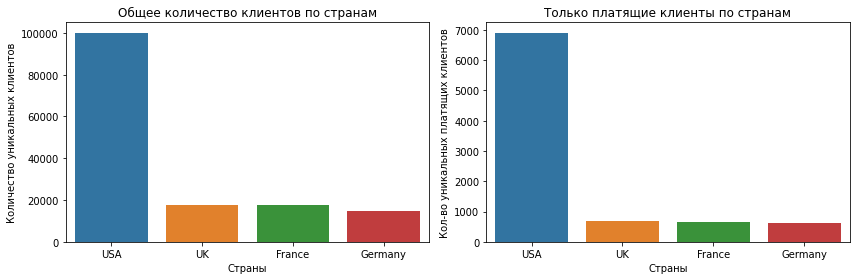

Таблица отсортирована по количеству платящих


,Страны,% клиентов от всей выборки,Кол-во клиентов,Кол-во платящих,% платящих,% платящих от всей выборки
0,USA,66.664,100002,6902,6.902,4.601
1,UK,11.716,17575,700,3.983,0.467
2,France,11.633,17450,663,3.799,0.442
3,Germany,9.987,14981,616,4.112,0.411


In [24]:
group_data({'Страны':'region'}, (12,4), ['Общее количество клиентов по странам'
                                         ,'Количество уникальных клиентов'
                                         ,'Только платящие клиенты по странам'
                                         ,'Кол-во уникальных платящих клиентов'
                                         ,0])

В выборке представлены клиенты из США, Великобритании, Франции и Германии.  
Больше всего клиентов и платящих клиентов из США, на втором и третьем местах - Великобритания и Франция.  
При этом доля платящих относительно страны у Германии немного (0,26%) больше, чем у Великобритании и Франции.

### Устройства
- Какими устройствами пользуются клиенты?  
- С каких устройств чаще всего заходят платящие клиенты?  
- Таблица, отражающая количество пользователей и долю платящих для каждого устройства.

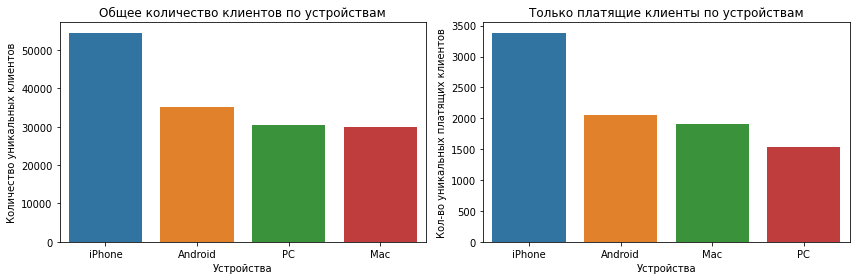

Таблица отсортирована по количеству платящих


,Устройства,% клиентов от всей выборки,Кол-во клиентов,Кол-во платящих,% платящих,% платящих от всей выборки
0,iPhone,36.317,54479,3382,6.208,2.255
1,Android,23.353,35032,2050,5.852,1.367
2,Mac,20.027,30042,1912,6.364,1.275
3,PC,20.302,30455,1537,5.047,1.025


In [25]:
group_data({'Устройства':'device'}, (12,4), ['Общее количество клиентов по устройствам'
                                             ,'Количество уникальных клиентов'
                                             ,'Только платящие клиенты по устройствам'
                                             ,'Кол-во уникальных платящих клиентов'
                                             ,0])

Клиенты используют следующие устройства - iPhone, Android, Mac, PC.  
Чаще всего используют iPhone, доли других устройств примерно равны - около 20%.   
Больше всего платящих приходит с iPhone,  
количество платящих с Android и Mac примерно одинаково, на последнем месте - PC.  
При этом доля платящих относительно устройства у Mac больше на 0,5%, чем у Android.

### Рекламные каналы
- По каким рекламным каналам шло привлечение пользователей?  
- Какие каналы приносят больше всего платящих пользователей?  
- Таблица, отражающая количество пользователей и долю платящих для каждого канала привлечения.

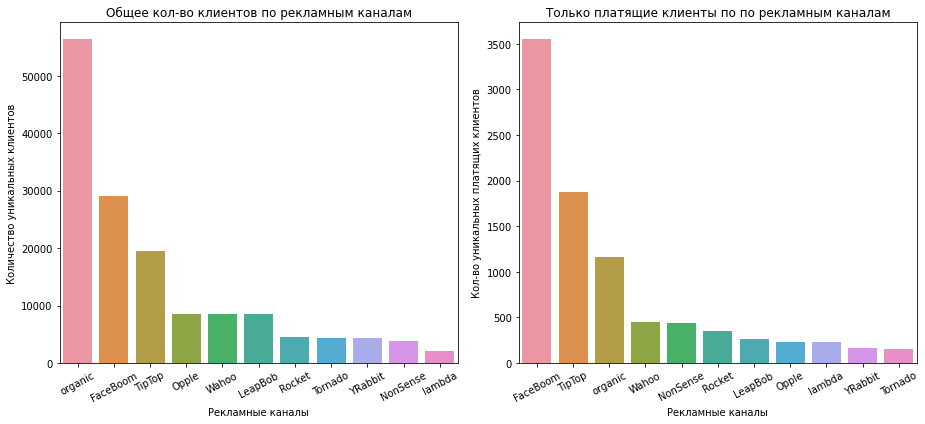

Таблица отсортирована по количеству платящих


,Рекламные каналы,% клиентов от всей выборки,Кол-во клиентов,Кол-во платящих,% платящих,% платящих от всей выборки
0,FaceBoom,19.428,29144,3557,12.205,2.371
1,TipTop,13.040,19561,1878,9.601,1.252
2,organic,37.624,56439,1160,2.055,0.773
3,Wahoo,5.702,8553,453,5.296,0.302
4,NonSense,2.587,3880,440,11.340,0.293
5,Rocket,2.965,4448,352,7.914,0.235
6,LeapBob,5.702,8553,262,3.063,0.175
7,Opple,5.736,8605,233,2.708,0.155
8,lambda,1.433,2149,225,10.470,0.150
9,YRabbit,2.875,4312,165,3.827,0.110


In [26]:
group_data({'Рекламные каналы':'channel'}, (13,6), ['Общее кол-во клиентов по рекламным каналам'
                                         ,'Количество уникальных клиентов'
                                         ,'Только платящие клиенты по по рекламным каналам'
                                         ,'Кол-во уникальных платящих клиентов'
                                         ,28])

Всего представлено 10 рекламных источников и 11-й - не рекламный канал organic.  

Если не рассматривать organic клиентов, то  

Количественно больше всего платящих пришло (в порядке убывания)  
с FaceBoom, TipTop, WahooNetBanner и AdNonSense.  
Меньше всего платящих привлекли lambdaMediaAds, YRabbit и MediaTornado.

Первые места по доли платящих занимают FaceBoom, AdNonSense и lambdaMediaAds.  
Последние места по доли - MediaTornado, LeapBob, OppleCreativeMedia.  

Несмотря на то, что organic составляет самую большую часть, 37,6% от всей выборки,  
у него самая маленькая доля среди платящих относительно канала привлечения.  
Тем не менее, по доли платящих ко всей выборке он занимает третье место.

Разобъем данные по парам "Страна - Устройство" и рассмотрим доли платящих в разрезе рекламных каналов.

In [27]:
#Функция отбирает платящих клиентов, группирует данные по паре регион - устройство
#и выводит для них круговые диаграммы в разрезе рекламных каналов
#
#Параметры:    df - датасет,
#              region     - название региона, 
#              cols_names - список, ключ - подпись к диаграмме, значение - название устройства,
#              top_cnt    - сколько записей  из топа нужно отобрать,
#              fsize      - общий размер графика
#              legend_loc - список, содержит значения положения легенды для каждого графика
#
def pie_chart(df, region, cols_names, top_cnt, fsize, legend_loc):
    
    if len(cols_names)==1:                             #если 1 колонка агрегации
        fig_cols = 1                                   #то у фигуры 1 колонка
        fig_rows = 1                                   # и 1 строка
    else:
        fig_cols = 2                                   #то у фигуры 2 колонки
        fig_rows = len(cols_names)* -1 // 2 * -1       #и количество строк

    fig, axes = plt.subplots(nrows = fig_rows ,ncols = fig_cols, squeeze=False, figsize =fsize)
    axes      = axes.flatten()        
    
    for i, (col_name, col) in enumerate(cols_names.items()):
  
        data_gr= (df.query('payer==True and region==@region')[['user_id','channel','device']]
                    .pivot_table(index='channel', columns='device', values='user_id', aggfunc='count')
                    .sort_values(by=col,ascending=False).head(top_cnt))
         
        data_gr.plot.pie(y=col, autopct = '%0.0f%%', ax=axes[i])
    
        axes[i].set_title(col_name)       
        axes[i].set_ylabel('')  
        
        axes[i].legend(loc=legend_loc[i])
        
    fig.tight_layout()

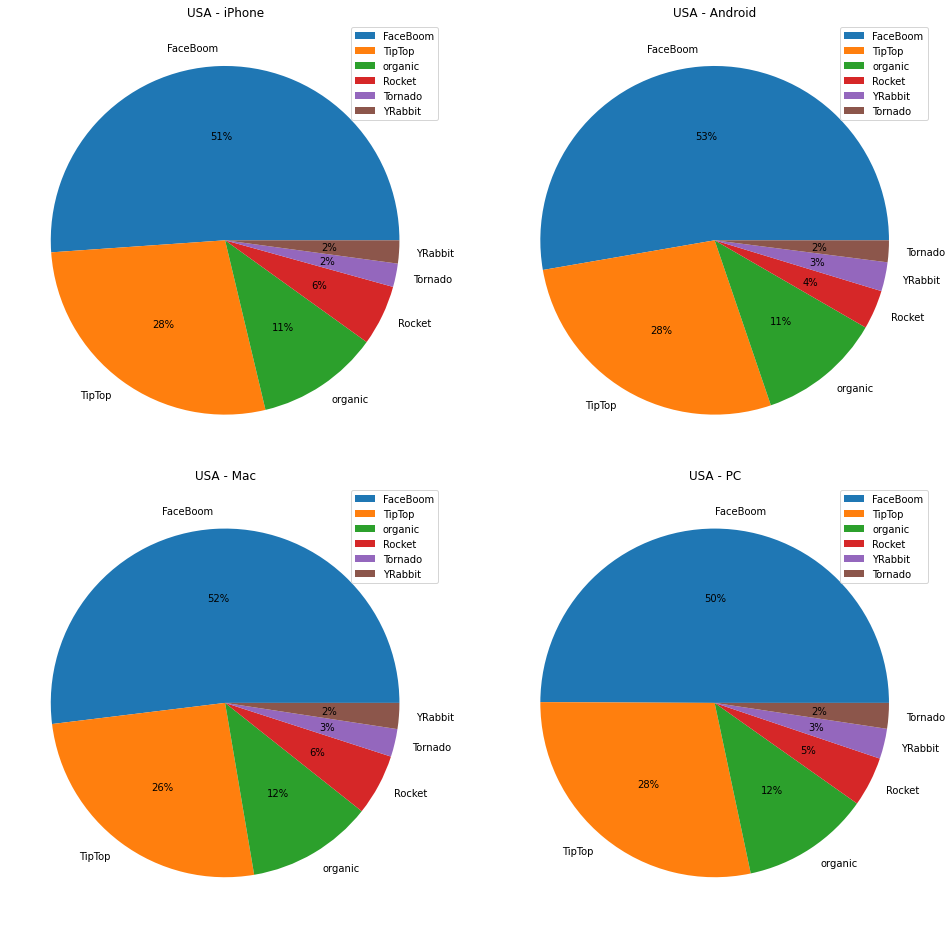

In [28]:
cols_names ={'USA - iPhone':'iPhone','USA - Android':'Android', 'USA - Mac':'Mac','USA - PC':'PC'}

pie_chart(profiles,'USA', cols_names, 6, (14,13), ['upper right']*4)

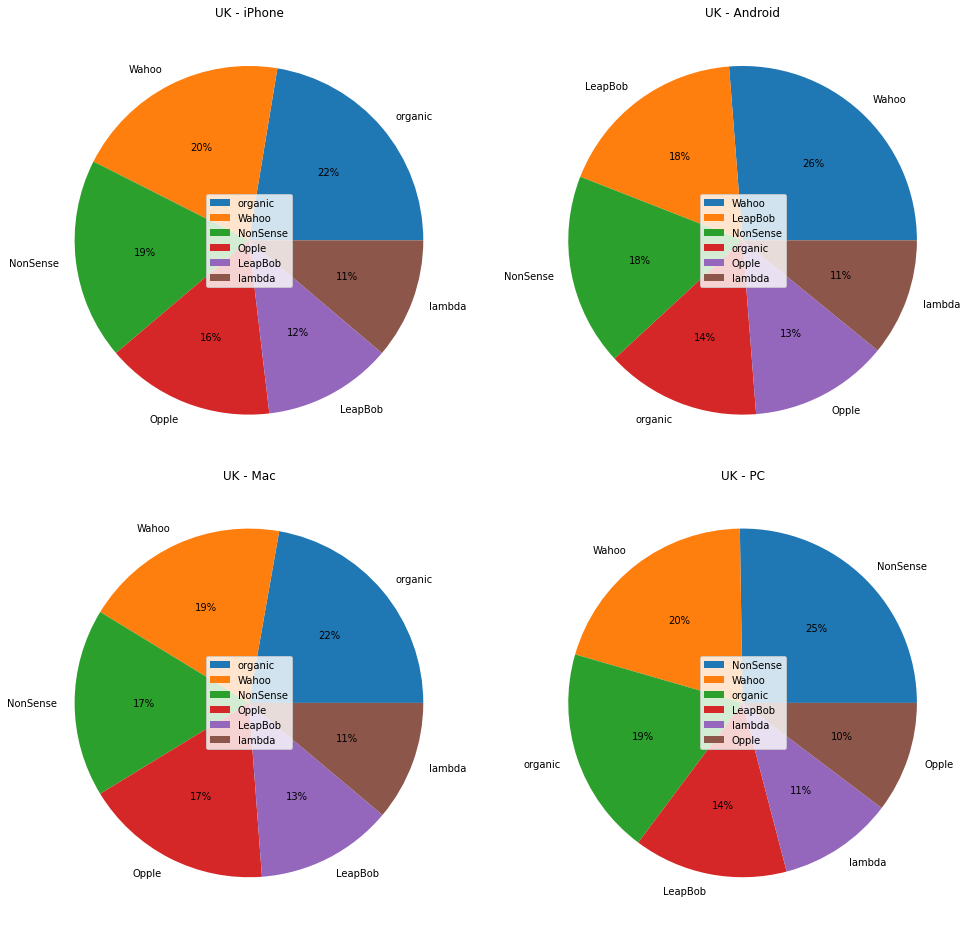

In [29]:
cols_names ={'UK - iPhone':'iPhone','UK - Android':'Android', 'UK - Mac':'Mac','UK - PC':'PC'}

pie_chart(profiles,'UK', cols_names, 6, (14,13), ['center']*4)

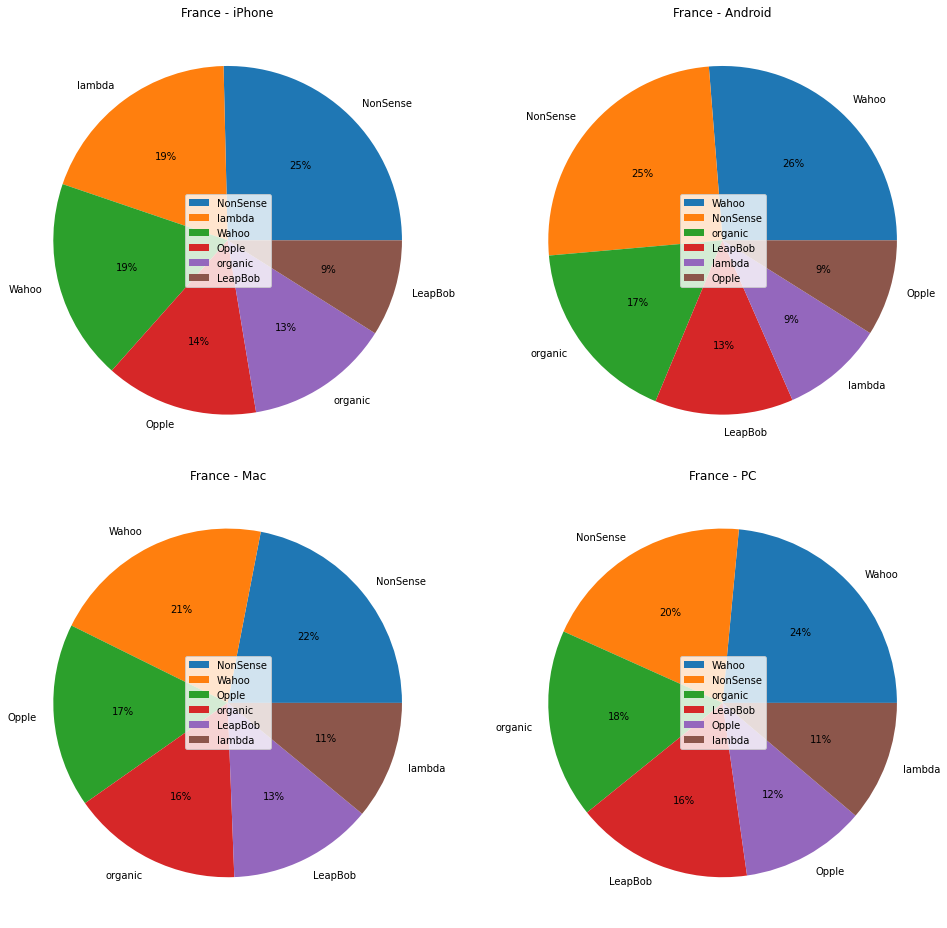

In [30]:
cols_names ={'France - iPhone':'iPhone','France - Android':'Android', 'France - Mac':'Mac','France - PC':'PC'}

pie_chart(profiles,'France', cols_names, 6, (14,13), ['center']*4)

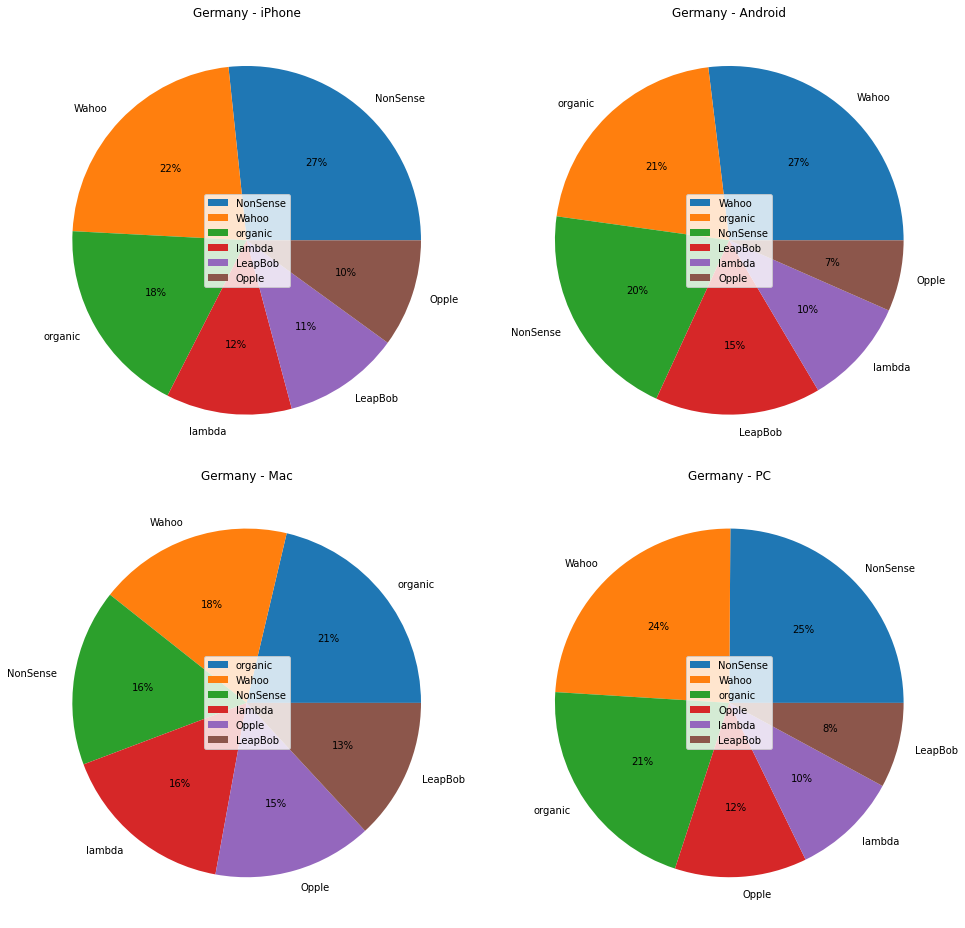

In [31]:
cols_names ={'Germany - iPhone':'iPhone','Germany - Android':'Android'
             ,'Germany - Mac':'Mac','Germany - PC':'PC'}

pie_chart(profiles,'Germany', cols_names, 6, (14,13), ['center']*4)

Графики построены только по платящим клиентам.  
Диграммы показывают, что рекламные каналы четко делятся по двум регионам - США и Европа.  

В США привлекают через FaceBoom, TipTop, RocketSuperAds, MediaTornado, YRabbit.  
Европейские рекламные каналы - WahooNetBanner, AdNonSense, LeapBob, OppleCreativeMedia, lambdaMediaAds.  

In [32]:
#количество платящих от каждого канала в разрезе устройств по сша
usa = (profiles.query('payer==True and region =="USA"')[['user_id','channel','device', 'region']]
               .pivot_table(index=['region','device'],columns='channel',values='user_id', aggfunc='count')
               .reset_index().drop('region', axis=1))
               
usa = (usa.groupby('device')
       .agg({'FaceBoom':'sum', 'TipTop':'sum', 'Rocket':'sum','YRabbit':'sum','Tornado':'sum','organic':'sum'})
       .sort_values(by=['FaceBoom'], ascending=False)
       [['FaceBoom', 'TipTop', 'Rocket','YRabbit','Tornado','organic']].T)
usa['sum'] = usa.sum(axis = 1)

print('Количество платящих в США по устройству/рекламному каналу')
display(usa)
print()
#количество платящих от каждого канала в разрезе устройств по странам Европы
eu = (profiles.query('payer==True and region !="USA"')[['user_id','channel','device', 'region']]
              .pivot_table(index=['region','device'],columns='channel',values='user_id', aggfunc='count')
              .reset_index()
              .drop('region', axis=1))

eu =(eu.groupby('device')
       .agg({'LeapBob':'sum','NonSense':'sum','Opple':'sum','Wahoo':'sum','lambda':'sum','organic':'sum'})
       .sort_values(by=['Wahoo'], ascending=False)
       [['Wahoo', 'NonSense', 'LeapBob', 'Opple', 'lambda', 'organic']].T)
eu['sum'] = eu.sum(axis = 1)
print('Количество платящих в Европе по устройству/рекламному каналу')
display(eu)

Количество платящих в США по устройству/рекламному каналу


device,iPhone,Mac,Android,PC,sum
FaceBoom,1530,886,784,357,3557
TipTop,827,439,409,203,1878
Rocket,168,97,54,33,352
YRabbit,64,41,40,20,165
Tornado,65,44,30,17,156
organic,340,199,170,85,794



Количество платящих в Европе по устройству/рекламному каналу


device,PC,Android,iPhone,Mac,sum
Wahoo,185,149,79,40,453
NonSense,192,118,91,39,440
LeapBob,107,87,41,27,262
Opple,93,54,52,34,233
lambda,87,57,55,26,225
organic,158,98,70,40,366


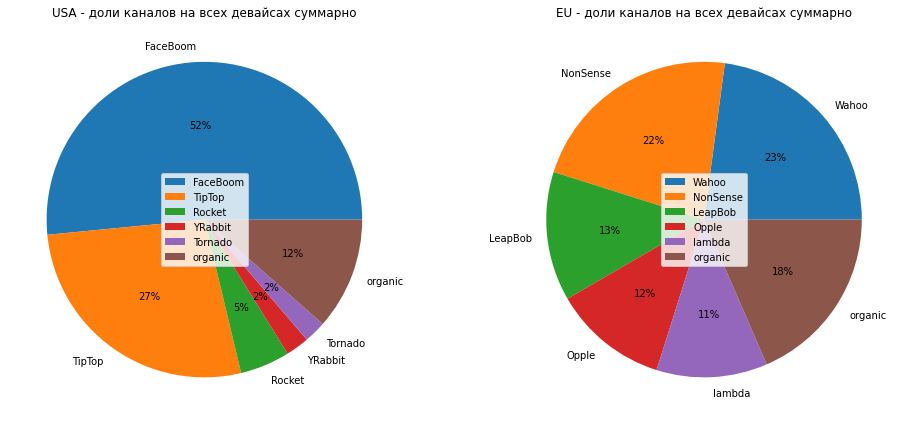

In [33]:
#доли платящих от каждого канала в разрезе устройств по макрорегионам
dfs = {'USA - доли каналов на всех девайсах суммарно':usa, 'EU - доли каналов на всех девайсах суммарно':eu}

fig, axes = plt.subplots(nrows = 1 ,ncols = 2, squeeze=False, figsize =(14,6))
axes      = axes.flatten()            
for i, (name, df) in enumerate(dfs.items()):
         
    df.plot.pie(y='sum', autopct = '%0.0f%%', ax=axes[i])    
    axes[i].set_title(name)       
    axes[i].set_ylabel('')          
    axes[i].legend(loc='center')
        
fig.tight_layout()

Распределение долей между каналами в США и Европе сильно отличается.  

В США  два лидера с примерно одинаковыми долями по разным устройствах - FaceBoom (50-52%) и TipTop (26-28%).  
FaceBoom приносит 52% от всех клиентов на всех устройствах суммарно.  
TipTop приносит 27% от всех клиентов на всех устройствах.  
RocketSuperAds, MediaTornado, YRabbit в сумме приносят всего 9% платящих.


В европейских странах есть два лидера, доля привлечения которых,  
менясь в парах "Страна - Устройство" в пределах 20-28%, составляет чуть меньше половины,  
это WahooNetBanner и AdNonSense.  
В сумме по всем устройствам в Европе они приносят 23% и 22% клиентов соответственно.  
Доли LeapBob, OppleCreativeMedia и lambdaMediaAds примерно одинаковы - от 11% до 13% суммарно по каждому.

То есть, в США чуть больше половины платящих приносит FaceBoom, чуть больше четверти - TipTop.  
А в Европе чуть меньше половины - WahooNetBanner и AdNonSense вместе взятые и 36% еще три канала.
  
Доля organic-платящих для пар "США - Устройство"  стабильна - 11-12%,  
а для пар "Страна Европы - Устройство" меняется в пределах 16-22%.  
Суммарно organic-платящих в странах Европы больше, чем в США.

**Вывод**  

Момент анализа данного проекта - 1 ноября 2019 года.  
Окупаемость должна наступать не позднее, чем через 2 недели после привлечения клиентов,  
поэтому за горизонт анализа принято 14 дней.

Минимальная дата привлечения пользователей - 1 мая 2019 г.  
Максимальная дата с учетом горизонта анализа - 19 октября 2019 г.

Клиенты приходят в приложение из 4 стран: США, Великобритании, Франции и Германии,  
пользуются iPhone, Android, Mac и PC.  
Количество рекламных каналов - 10.  

Количественно большинство платящих по всей выборке  
в разбивке по странам приходят из США,  
в разбивке по устройствам они - пользователи iPhone,  
в разбивке по рекламным каналам - больше всего дают FaceBoom, TipTop, WahooNetBanner и AdNonSense.  

При рассмотрении пар "Страна - Устройство" в разрезе каналов привлечения платящих, выяснилось, что:  

- рекламные каналы разные для США и стран Европы, между собой они не пересекаются,   
- в США это FaceBoom, TipTop, RocketSuperAds, MediaTornado, YRabbit,
- в Европе - WahooNetBanner, AdNonSense, LeapBob, OppleCreativeMedia, lambdaMediaAds.  

Рекламные каналы в США и странах Европы сильно различается по долям внутри макрорегионов:   
- в США доминирут два канала: FaceBoom - 52% суммарно по всем устройствам, TipTop - 27% по всем устройствам,  
- в Европе два канала, WahooNetBanner и AdNonSense приносят, 23% и 22% соответственно,  
- 36% платящих распределены примерно одинаково еще по трем каналам,  
- доля organic-платящих для пар "США -Устройство" стабильна - 11-12%,  
- доля organic-платящих в Европе меняется в пределах 13-22% в разных парах "Страна- Устройство",  
а суммарно она больше, чем в США.

## Маркетинг

### Сколько денег потратили на рекламу - всего / на каждый источник / по времени 

In [34]:
#всего потратили на рекламу
print(round(costs.costs.sum(), 2))

#проверим, что в профилях та же сумма
print('Общая сумма расходов на рекламу',round(profiles['acquisition_cost'].sum(),2))

105497.3
Общая сумма расходов на рекламу 105497.3


In [35]:
#траты на рекламу по месяцам 
costs['month_costs'] =  np.nan

groups = costs.groupby('month')['costs'].transform('sum')
costs['month_costs'] = costs['month_costs'].fillna(groups)

month_costs = costs.groupby('month').agg({'costs': 'sum'})
month_costs['Доля расходов'] = round(month_costs['costs']/month_costs['costs'].sum()*100, 2)
print('Расходы на рекламу по месяцам')
month_costs

Расходы на рекламу по месяцам


,costs,Доля расходов
month,,
2019-05-01,9978.570,9.46
2019-06-01,15090.045,14.30
2019-07-01,16447.060,15.59
2019-08-01,20657.870,19.58
2019-09-01,22441.340,21.27
2019-10-01,20882.415,19.79


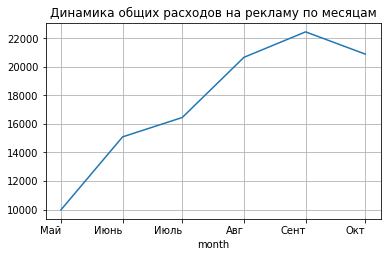

In [36]:
(profiles.groupby('month')['acquisition_cost'].sum()
         .sort_values(ascending=False).plot(grid=True))

plt.xticks(list(profiles['month'].sort_values().unique())
           ,['Май', 'Июнь','Июль', 'Авг', 'Сент', 'Окт'], rotation=0)

plt.title('Динамика общих расходов на рекламу по месяцам')
plt.show()

С июня по сентябрь расходы на рекламу постоянно увеличивались, в октябре немного снизились.

In [37]:
#потратили на каждый канал
costs_sum = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

#второй вариант для проверки правильности расчетов
cost_by_channel = profiles.groupby('channel')['acquisition_cost'].sum().sort_values(ascending=False)

costs_sum = costs_sum.merge(cost_by_channel, on='channel', how='left')

costs_sum['Доля расходов'] = round(costs_sum['costs']/costs_sum['costs'].sum()*100, 2)

print('Расходы на рекламу по каждому рекламному каналу')
costs_sum

Расходы на рекламу по каждому рекламному каналу


,costs,acquisition_cost,Доля расходов
channel,,,
TipTop,54751.30,54751.30,51.90
FaceBoom,32445.60,32445.60,30.75
Wahoo,5151.00,5151.00,4.88
NonSense,3911.25,3911.25,3.71
Opple,2151.25,2151.25,2.04
Rocket,1833.00,1833.00,1.74
LeapBob,1797.60,1797.60,1.70
lambda,1557.60,1557.60,1.48
Tornado,954.48,954.48,0.90


Расходы на TipTop, FaceBoom, WahooNetBanner гораздо больше, чем на другие каналы.  
Меньше всего тратилось на YRabbit и MediaTornado.

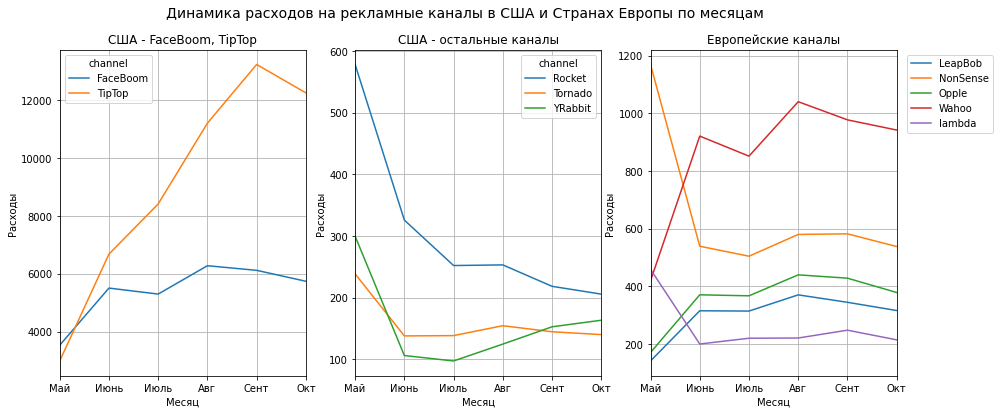

In [38]:
plt.figure(figsize=(15, 6))
plt.suptitle('Динамика расходов на рекламные каналы в США и Странах Европы по месяцам', fontsize=14)

ax1 = plt.subplot(1, 3, 1)       
(profiles.query('region=="USA" and channel == ("FaceBoom", "TipTop")')
         .pivot_table(index='month', columns='channel',values='acquisition_cost', aggfunc='sum')
         .plot(grid=True, ax=ax1))

plt.title('США - FaceBoom, TipTop')
plt.xlabel('Месяц')
plt.xticks(list(profiles['month'].sort_values().unique())
           ,['Май', 'Июнь','Июль', 'Авг', 'Сент', 'Окт'], rotation=0)
plt.ylabel('Расходы')

ax2 = plt.subplot(1, 3, 2)    
(profiles.query('region=="USA" and channel != ("FaceBoom", "TipTop", "organic")')
         .pivot_table(index='month', columns='channel',values='acquisition_cost', aggfunc='sum')
         .plot(grid=True, ax=ax2))

plt.title('США - остальные каналы')
plt.xlabel('Месяц')
plt.xticks(list(profiles['month'].sort_values().unique())
           ,['Май', 'Июнь','Июль', 'Авг', 'Сент', 'Окт'], rotation=0)
plt.ylabel('Расходы')

ax3 = plt.subplot(1, 3, 3)  
(profiles.query('region !="USA" and channel != "organic"')
         .pivot_table(index='month', columns='channel',values='acquisition_cost', aggfunc='sum')
         .plot(grid=True, ax=ax3))

plt.title('Европейские каналы')
plt.xlabel('Месяц')
plt.xticks(list(profiles['month'].sort_values().unique())
           ,['Май', 'Июнь','Июль', 'Авг', 'Сент', 'Окт'], rotation=0)
plt.ylabel('Расходы')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best')
plt.show()

Расходы на TipTop, FaceBoom, WahooNetBanner постоянно повышались с июня по сентябрь,  
небольшое снижение было в октябре.  

Расходы на RocketSuperAds, MediaTornado, YRabbit, AdNonSense, lambdaMediaAds  
понизились в июне и оставались примерно на одном уровне с небольшими колебаниями до конца изучаемого периода.  

Расходы на OppleCreativeMedia, LeapBop  
повысились с июне и и оставались примерно на одном уровне с небольшими колебаниями до конца изучаемого периода.  

За июнь- октябрь
- на TipTop тратилось от 4000 у.е. до 13 000 у.е. в месяц,  
- на FaceBoom  4000 - 6000 у.е. в месяц,
- WahooNetBanner 400 - 1000 у.е. в месяц,  
- на остальные каналы - в пределах 100 - 600 у.е. в месяц на каждый.

**Вывод**  
Общий бюджет на рекламу за изучаемый период - 105 497.3 у.е.  
Около 52% этой суммы было потрачено на FaceBoom, около 31% - на TipTop, около 5% - на WahooNetBanner.  
С июня по сентябрь расходы на рекламу постоянно увеличивались (с небольшим снижением в октябре),  
это увеличение касалось практически только TipTop, FaceBoom, WahooNetBanner.  

### Средняя стоимость привлечения одного клиента
- Средний CAC на одного клиента для всего проекта,  
- Средний CAC для каждого источника трафика.

Установим момент и горизонт анализа данных по условиям проекта:
- момент анализа - 1-го ноября 2019 года,  
- горизонт анализа - 14 дней (2 недели).

In [39]:
#момент анализа
analysis_day = datetime(2019, 11, 1).date()

#горизонт анализа
horizon = 14

In [40]:
#используем функцию расчета ltv, т.к. в ней же есть расчет cac по каналам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders
                                                      ,analysis_day
                                                      ,horizon, dimensions=['channel'])

In [41]:
print('Средняя стоимость привлечения клиента по каждому источнику трафика, у.е.')
round(roi['cac'].sort_values(ascending=False),2)

Средняя стоимость привлечения клиента по каждому источнику трафика, у.е.


channel
TipTop      2.76
FaceBoom    1.11
NonSense    1.01
lambda      0.73
Wahoo       0.60
Rocket      0.42
Opple       0.25
Tornado     0.22
YRabbit     0.22
LeapBob     0.21
Name: cac, dtype: float64

Самые дорогие по стоимости привлечения клиенты пришли с TipTop, FaceBoom, AdNonSense.  
На втором месте по среднему CAC - lambdaMediaAds, WahooNetBanner, RocketSuperAds.  

Самый низкий средний CAC у OppleCreativeMedia, MediaTornado, YRabbit, LeapBob.

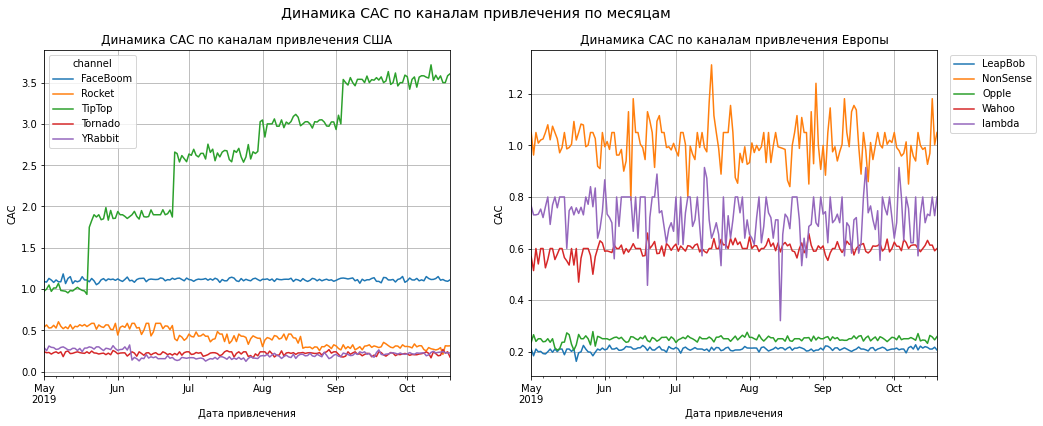

In [42]:
usa_roi_history = roi_history.query('channel in ("TipTop", "FaceBoom", "Rocket", "YRabbit","Tornado")')
eu_roi_history = roi_history.query('channel in ("Wahoo", "LeapBob", "Opple", "NonSense","lambda")')

#график истории изменений CAC по каналам
plt.figure(figsize=(16, 6))
plt.suptitle('Динамика CAC по каналам привлечения по месяцам', fontsize=14)

ax1 = plt.subplot(1, 2, 1)  
(usa_roi_history.pivot_table(index='dt', columns='channel', values='cac', aggfunc='mean')
                .plot(grid=True,  ax=ax1))
 
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения США')

ax2 = plt.subplot(1, 2, 2)    
(eu_roi_history.pivot_table(index='dt', columns='channel', values='cac', aggfunc='mean')
               .plot(grid=True,  ax=ax2))

plt.title('Динамика САС по каналам привлечения Европы')
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best')
plt.show()

Хорошо видно, что средняя стоимость привлечения клиента  
резко повышается каждый месяц (кроме октября) для канала TipTop.  

Для канала RocketSuperAds CAC немного понижается с течением времени.  

Средний CAC YRabbit, MediaTornado, FaceBoom, LeapBob, OppleCreativeMedia, WahooNetBanner не меняется.  

Для канала AdNonSense средний CAC меняется в пределах примерно от 0,8 - 1,2 у.е.  
Для канала lambdaMediaAds средний CAC меняется в пределах примерно от 0,6 - 0,8 у.е  
(с однократным понижением до 0,3 у.е. в середине августа).  

In [43]:
#средний сас по всему проекту
print('Средняя стоимость привлечения одного клиента для всего проекта'\
      ,round(roi['cac'].mean(),2), 'у.е.')

Средняя стоимость привлечения одного клиента для всего проекта 0.75 у.е.


**Вывод**  
Самые дорогие по средней стоимости привлечения клиенты пришли с TipTop, FaceBoom, AdNonSense.  
На втором месте по среднему CAC - lambdaMediaAds, WahooNetBanner, RocketSuperAds.  
Самый низкий средний CAC у OppleCreativeMedia, MediaTornado, YRabbit, LeapBob.  

CAC резко повышается каждый месяц (кроме октября) для TipTop.  
Для RocketSuperAds CAC немного понижается с течением времени.  
Средний CAC YRabbit, MediaTornado, FaceBoom, LeapBob, OppleCreativeMedia, WahooNetBanner не меняется.  
Для AdNonSense, lambdaMediaAds средний CAC меняется в небольших коридрах значений в изучаемый период.  

Средняя стоимость привлечения одного клиента для всего проекта равна 0.75 у.е.  

## Оценка окупаемости рекламы для привлечения пользователей
При анализе и оценке данных исходим из того, что:
- момент анализа данного проекта - 1-го ноября 2019 года,  
- окупаемость должна наступать не позднее, чем через 2 недели после привлечения клиентов,  
поэтому изучаются метрики 14 дня «жизни» клиентов.

Для оценки окупаемости рекламы изучим следующие бизнес-показатели:  

LTV (Lifetime Value), —  «пожизненная ценность» клиента, общая сумма денег,  
которую он в среднем приносит со всех покупок за некоторый период.  

ROI (Return On Investment), — окупаемость инвестиций.  
На сколько процентов LTV превысил CAC (на сколько % окупились клиенты).  

LTV и ROI никогда не снижаются (потому что рассчитываются с накоплением).  

CAC (Customer Acquisition Cost), — стоимость привлечения одного клиента.  
CAC когорты — постоянная величина для всех лайфтаймов.  

RR (Retention Rate) показывает, сколько клиентов из когорты относительно их изначального числа  
вернулись в последующие периоды.  
Чем дольше привлечённый клиент пользуется продуктом, тем больше потенциальная выручка.  

CR (Conversion Rate), — процент клиентов из когорты, совершивших какое-нибудь действие.  
Чем выше % покупателей в когортах, тем лучше для компании.

Так как проводится анализ рекламы, то из датасета profiles нужно убрать organic-клиентов.  

In [44]:
profiles = profiles.query('channel != "organic"')

### Анализ общей окупаемости рекламы

In [45]:
#получаем метрики без разделения по признаку
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, analysis_day, horizon)

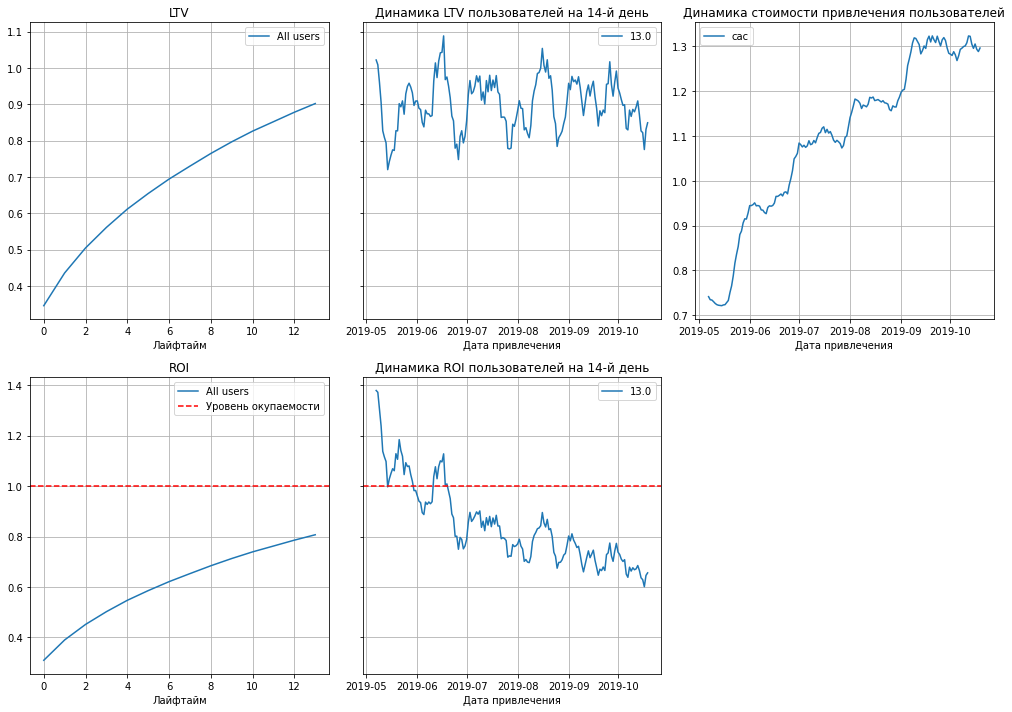

In [46]:
#строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7)

Реклама в целом по проекту не окупается.  
ROI в конце второй недели — чуть выше 80%, график динамики показывает постоянное понижение с июня.  
LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.  

CAC постоянно растет с июня. Скорее всего, дело в увеличении рекламного бюджета.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам клиентов —  
стране, источнику привлечения устройству первого посещения.

### Анализ окупаемости рекламы по странам

In [47]:
#получаем метрики в разрезе стран
ltv_raw, ltv, ltv_history, roi, roi_history =get_ltv(profiles,orders,analysis_day,horizon,dimensions=['region'])

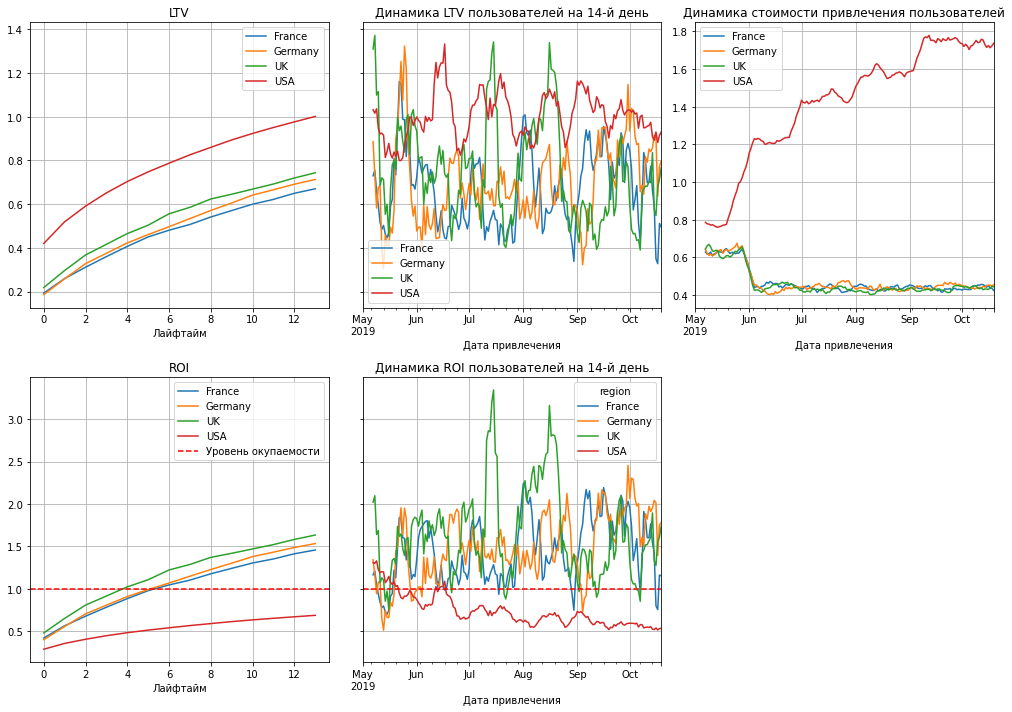

In [48]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7)

LTV подвержен сезонности.  

CAC резко отличается для Европы и США.  
Стоимость привлечения стабильна и примерно одинакова для стран Европы.  
CAC для США постоянно растет, начиная с июня.  

Быстрее всего реклама окупается в Великобритании - начиная с 5 дня жизни клиентов.  
ROI показывает, что реклама не окупается в США.

**Вывод**  
На окупаемость негативно влияет большой бюджет на рекламу в США.

Рассмотрим удержание и конверсию по странам.

In [49]:
#получаем метрики в разрезе стран
retent_raw, retent, retent_history = get_retention(profiles,visits,analysis_day,horizon, dimensions=['region'])

convers_raw, convers, convers_history = get_conversion(profiles, orders,analysis_day,horizon, dimensions=['region'])

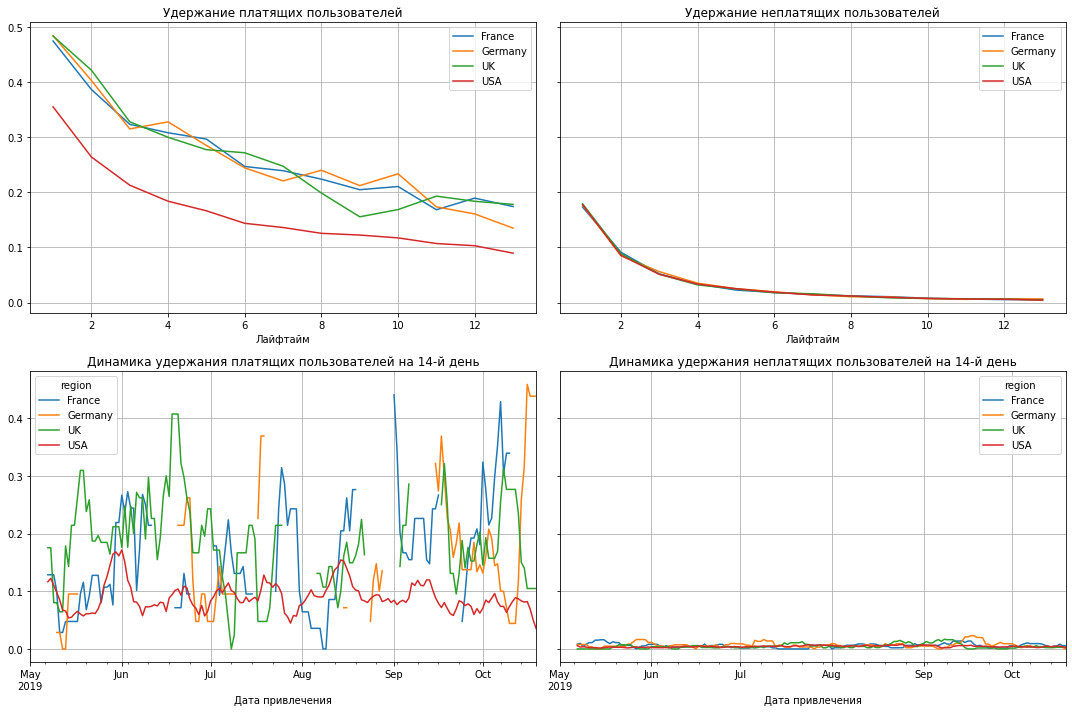

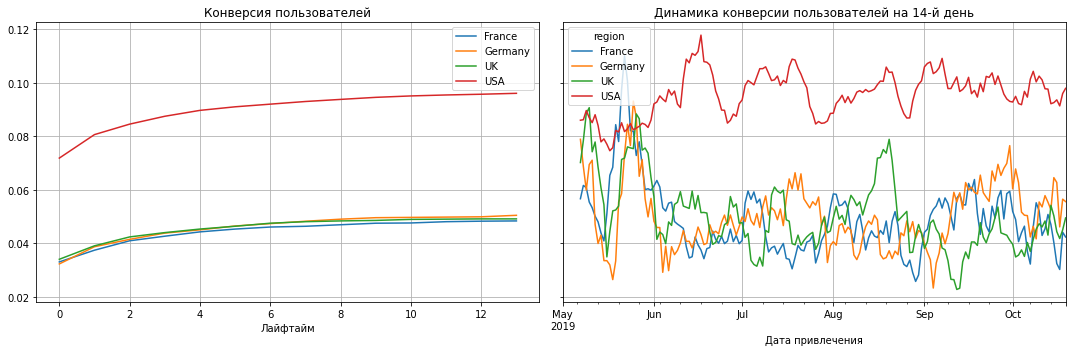

In [50]:
#строим графики
plot_retention(retent, retent_history, horizon, window=7)
plot_conversion(convers, convers_history, horizon, window=7)

**Удержание платящих по странам**  
На 14 день «жизни» коэффициент удержания по убыванию - Великобритания и Франция, Германия, США.

Удержание 14 дня по всем странам меняется во времени.  
Британские пользователи не всегда удерживались лучше всех.  
Новые пользователи из Франции, привлечённые в начальных числах сентября и октября,  
и клиенты из Германии, пришедшие в конце октября, удерживались лучше всего.  
 
Самое низкое удержание у США, его график самый стабильный, т.к чем больше группа, тем стабильнее метрики.  

Удержание неплатящих практически совпадает для всех стран, и,  
как всегда, значительно стабильнее и ниже, чем удержание платящих.  

**Коэффициент конверсии**  
Коэффициент удержания выше всего у США: около 7,2% новых пользователей совершают покупки в день первого посещения,  
а к 14 дню «жизни» доля покупателей достигает примерно 9,8%.  
Конверсия стран Европы очень близка по значениям.  
Хуже всего конвертируются пользователи из Франции.  
Для всех стран рост конверсии сильно замедляется с 9 дня жизни.  

Динамика конверсии 14 дня для США показывает, что хуже всего конвертировались клиенты,  
привлеченные в мае, самые высокие значения у июльских когорт.  
Конверсия по странам Европы подвержена сезонности, но в целом стабильна.  
Самая высокая конверсия была у клиентов из Франции, привлеченных во второй половине мая.  

**Вывод**  
Проблемы рекламных кампаний в разрезе стран: у клиентов из США очень низкое удержание при этом реклама самая дорогая.

### Анализ окупаемости рекламы  по каналам привлечения
Из исследовательского анализа известно,  
что есть две непересекющиеся группы каналов привлечения - для США и для Европы.  
Уже выяснено, что реклама в США не окупается,  
поэтому будет логично провести последующий анализ по каналам и устройствам в разрезе двух макрорегионов.  
К тому же, благодаря разделению, будут лечге читаться графики.

In [51]:
#разделим изначальный датасет на два - один с клиентами из США, другой - с клиентами из Европы
usa_profiles = profiles.query('region == "USA"')
eu_profiles  = profiles.query('region != "USA"')

In [52]:
#получаем метрики в разрезе рекламных каналов США
usa_ltv_raw, usa_ltv, usa_ltv_history, usa_roi, usa_roi_history = get_ltv(usa_profiles, orders,analysis_day
                                                                          ,horizon, dimensions=['channel'])

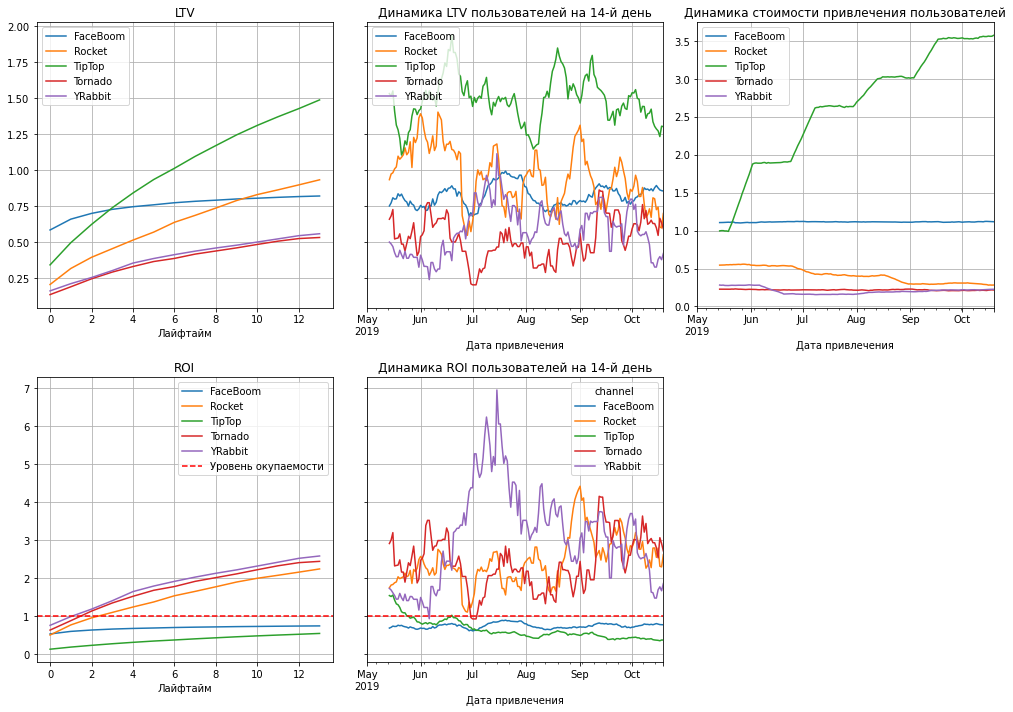

In [53]:
#строим графики США
plot_ltv_roi(usa_ltv, usa_ltv_history, usa_roi, usa_roi_history, horizon, window=14)

LTV 14 дня жизни в разрезе рекламных каналов для США подвержен сезонности, но в целом стабилен.  

Стоимость привлечения самая низкая, почти одинаковая и постоянноая у YRabbit и MediaTornado,  

CAC у RocketSuperAds постепенно снижается в изучаемом периоде, скорее всего, из-за этого,  
LTV RocketSuperAds становится выше LTV FaceBoom с  11 дня жизни клиентов.  

CAC FaceBoom не меняется, а вот CAC TipTop постоянно растет.

Реклама не окупается на каналах  FaceBoom и TipTop (несмотря на то, что у TipTop самый высокий LTV).  
Остальные каналы окупаются хорошо - начиная с 2-3 дней жизни клиентов.  

**Вывод**  
На окупаемость каналов США негативно влияет постоянное повышение расходов на рекламу в TipTop  
и довольно дорогая реклама FaceBoom.

Удержание и конверсия

In [54]:
#получаем метрики в разрезе рекламных каналов для США
usa_retent_raw, usa_retent, usa_retent_history = get_retention(usa_profiles, visits
                                                               ,analysis_day, horizon, dimensions=['channel'])
usa_convers_raw, usa_convers, usa_convers_history = get_conversion(usa_profiles, orders
                                                                   ,analysis_day, horizon, dimensions=['channel'])

Рекламные каналы США


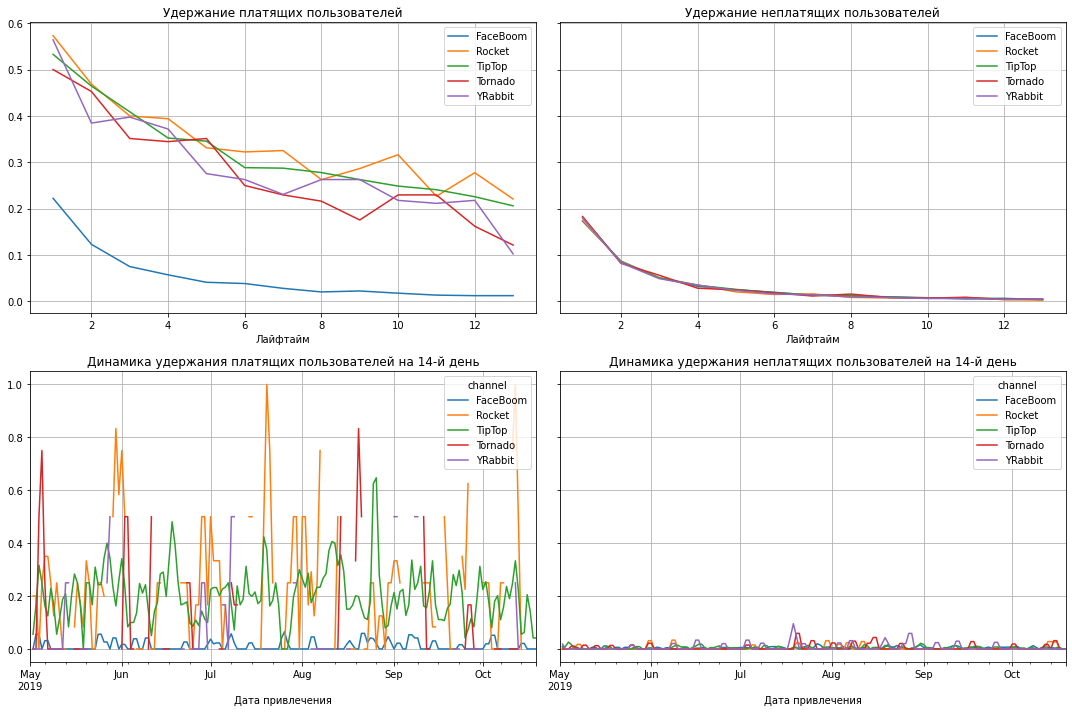

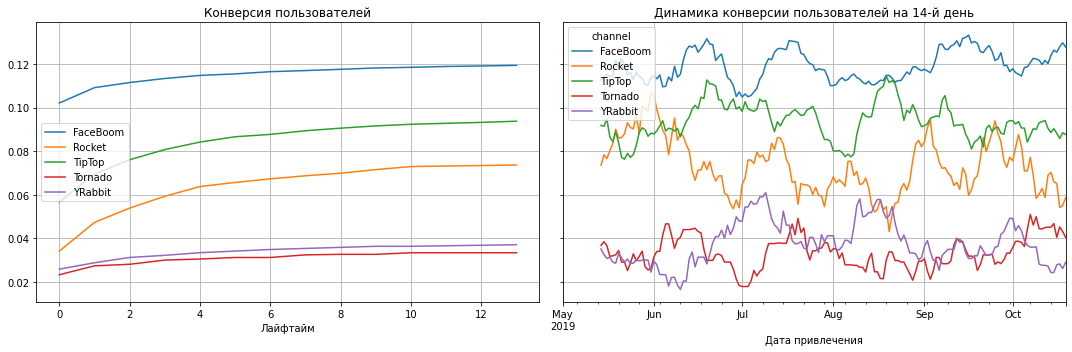

In [55]:
#строим графики для каналов США
print('Рекламные каналы США')
plot_retention(usa_retent, usa_retent_history, horizon, window=2)
plot_conversion(usa_convers, usa_convers_history, horizon, window=14)

**Удержание платящих по рекламным каналам США**  
На 14 день «жизни» коэффициент удержания самый низкий у FaceBoom.  

**Коэффициент конверсии  по рекламным каналам США**  
На 14 день «жизни» коэффициент конверси в порядке убывания:  
FaceBoom,  TipTop, RocketSuperAds, YRabbit, MediaTornado.  

Конверсия FaceBoom: около 10,2% новых пользователей совершают покупки в день первого посещения,  
а к 14 дню «жизни» доля покупателей достигает 12%.  
Хуже всего конвертируются пользователи MediaTornado и YRabbit.  
Динамика конверсии по всем каналам довольно сглаженная.  

**Вывод**  
Проблемы рекламных кампаний в разрезе каналов привлечения США:  
у клиентов, пришедших с FaceBoom, очень низкое удержание, при этом реклама довольно дорога.  
у клиентов, пришедших с  MediaTornado, YRabbit низкая конверсия.  
Реклама в TipTop не окупается, при постоянном повышении расходов на нее каждый месяц.  

In [56]:
#получаем метрики в разрезе рекламных каналов для Европы
eu_ltv_raw, eu_ltv, eu_ltv_history, eu_roi, eu_roi_history = get_ltv(eu_profiles, orders,analysis_day
                                                                     ,horizon, dimensions=['channel'])    

Рекламные каналы стран Европы


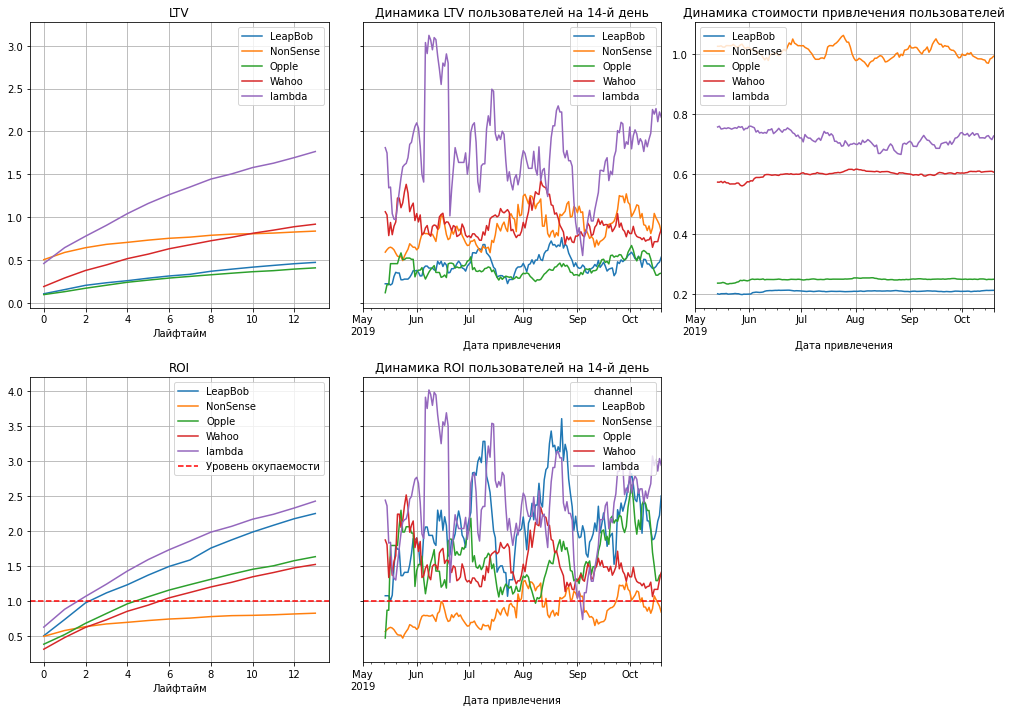

In [57]:
#строим графики для каналов Европы
print('Рекламные каналы стран Европы')
plot_ltv_roi(eu_ltv, eu_ltv_history, eu_roi, eu_roi_history, horizon, window=14)

LTV 14 дня жизни европейского рекламного канала lambdaMediaAds очень нестабилен,  
у остальный каналов подвержен сезонности, но достаточно стабилен.  
Стоимость привлечения почти постоянная, значит, дело не в увеличении рекламного бюджета.

Самый дорогой CAC у AdNonSense и это единственный канал, реклама на котором в Европе не окупается.

Каналы lambdaMediaAds и LeapBob окупаются быстрее всего - к 3 дню жизни клиентов.  
При этом у LeapBob стабильный и самый низкий CAC.  
OppleCreativeMedia и WahooNetBanner на 5 и 6 дни соответственно.  

**Вывод**  
На окупаемость в странах Европы негативно влияет довольно дорогая реклама на AdNonSense.

In [58]:
#получаем метрики в разрезе рекламных каналов для Европы
eu_retent_raw, eu_retent, eu_retent_history = get_retention(eu_profiles, visits
                                                               ,analysis_day, horizon, dimensions=['channel'])
eu_convers_raw, eu_convers, eu_convers_history = get_conversion(eu_profiles, orders
                                                                   ,analysis_day, horizon, dimensions=['channel'])

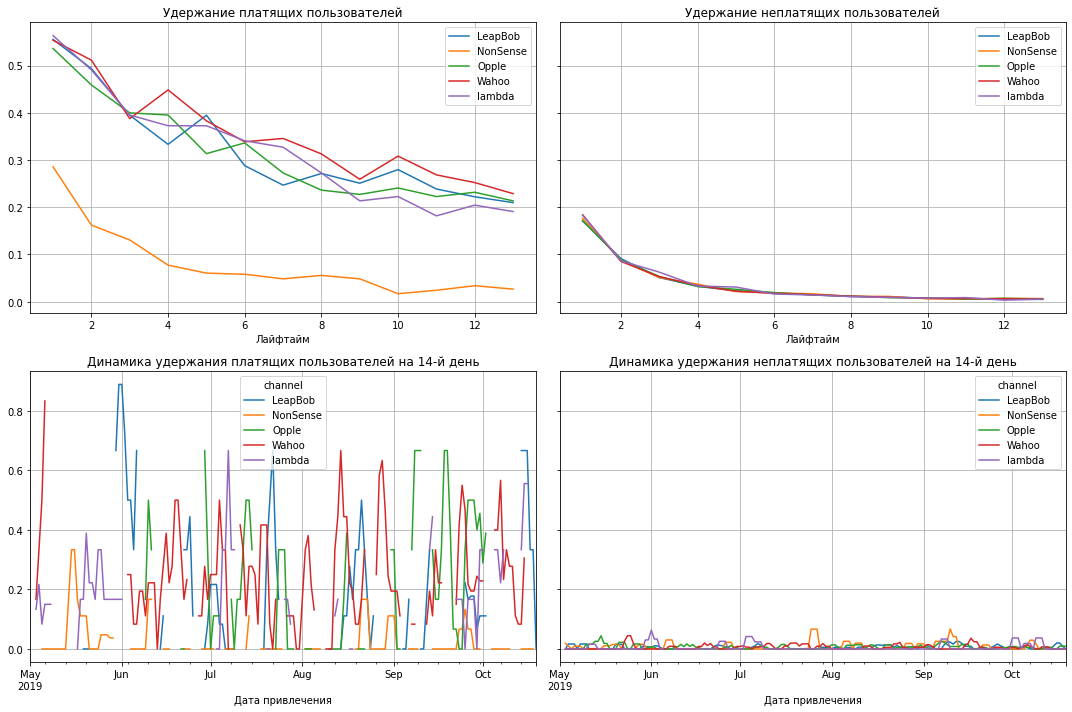

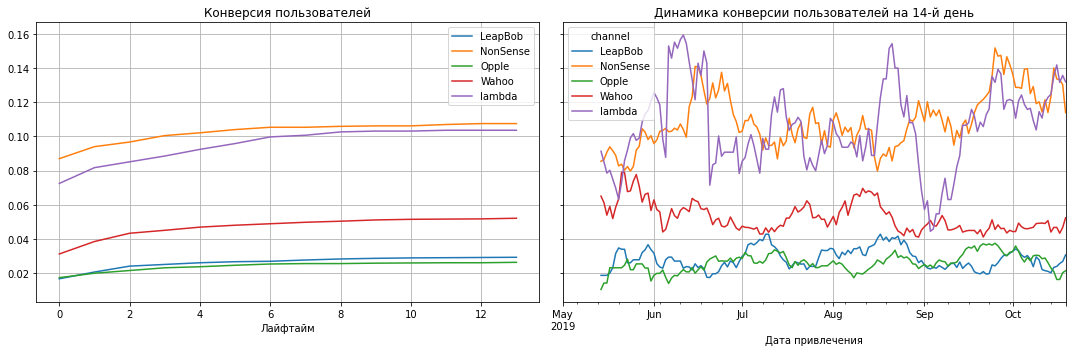

In [59]:
#строим графики для каналов Европы
plot_retention(eu_retent, eu_retent_history, horizon, window=3)
plot_conversion(eu_convers, eu_convers_history, horizon, window=14)

**Удержание платящих по рекламным каналам Европы**  
На 14 день «жизни» коэффициент удержания самый низкий у AdNonSense.  

**Коэффициент конверсии  по рекламным каналам Европы**  
Коэффициент конверсии самый высокий у AdNonSense:  
около 9% новых клиентов совершают покупки в день первого посещения,  
а к 14 дню «жизни» доля покупателей достигает примерно 11%.  
lambdaMediaAds очень близка по конверсии к лидеру.

Хуже всего конвертируются пришедшие с LeapBob и OppleCreativeMedia.  

Динамика конверсии 14 дня канала lambdaMediaAds сильно меняется с течением времени:  
хуже всего конвертировались клиенты из когорт первых чисел сентября,  
лучше всего - июньские и второй половины августа.  
Динамика конверсии по остальным каналам стабильна.

**Вывод**  
В целом реклама в Европе окупается, но есть несколько проблемных мест:  
у клиентов, пришедших с AdNonSense, очень низкое удержание при довольно высокой стоимости рекламы,  
у клиентов, пришедших с WahooNetBanner, низкая конверсия при недешевой рекламе,         
у клиентов, пришедших с  OppleCreativeMedia, LeapBob, низкая конверсия (но зато самая дешевая реклама).

### Анализ окупаемости рекламы по устройствам

In [60]:
#получаем метрики в разрезе устройств и для макрорегиона Европа
eu_dev_ltv_raw, eu_dev_ltv, eu_dev_ltv_history, eu_dev_roi, eu_dev_roi_history = get_ltv(eu_profiles, orders,analysis_day
                                                                                       ,horizon,dimensions=['device'])

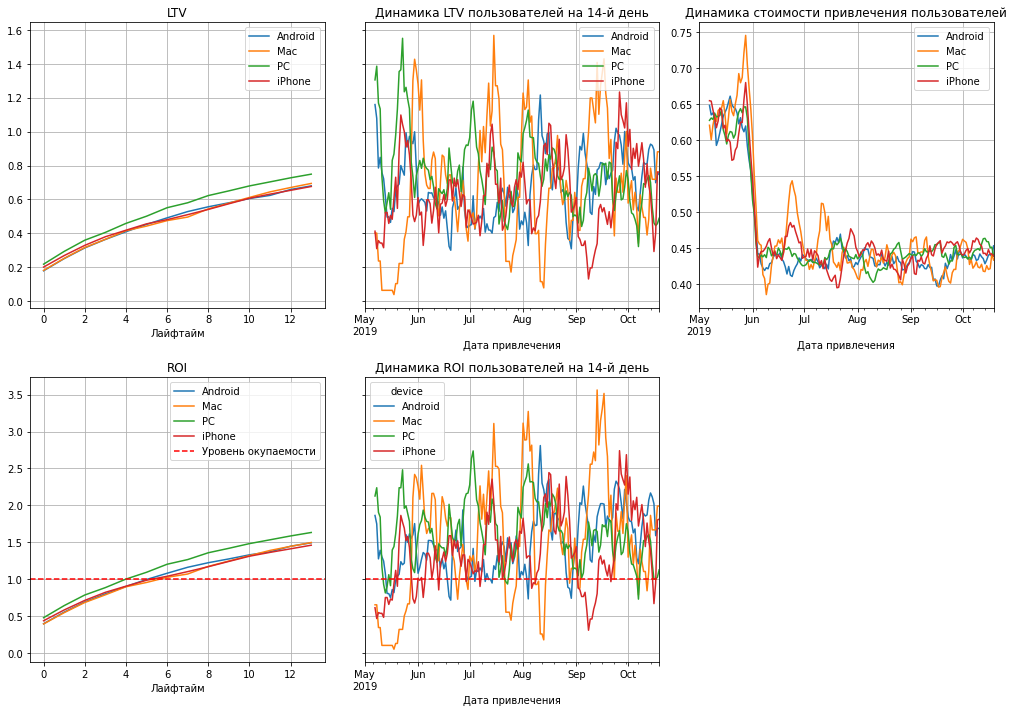

In [61]:
#строим графики в разрезе устройств и для макрорегиона Европа
plot_ltv_roi(eu_dev_ltv, eu_dev_ltv_history, eu_dev_roi, eu_dev_roi_history, horizon, window=7)

Реклама на всех устройствах в странах Европы окупается на 6 - 7 дни жизни клиентов.

In [62]:
#получаем метрики в разрезе рекламных каналов для Европы
eu_dev_retent_raw, eu_dev_retent, eu_dev_retent_history = get_retention(eu_profiles, visits
                                                               ,analysis_day, horizon, dimensions=['device'])
eu_dev_convers_raw, eu_dev_convers, eu_dev_convers_history = get_conversion(eu_profiles, orders
                                                                   ,analysis_day, horizon, dimensions=['device'])

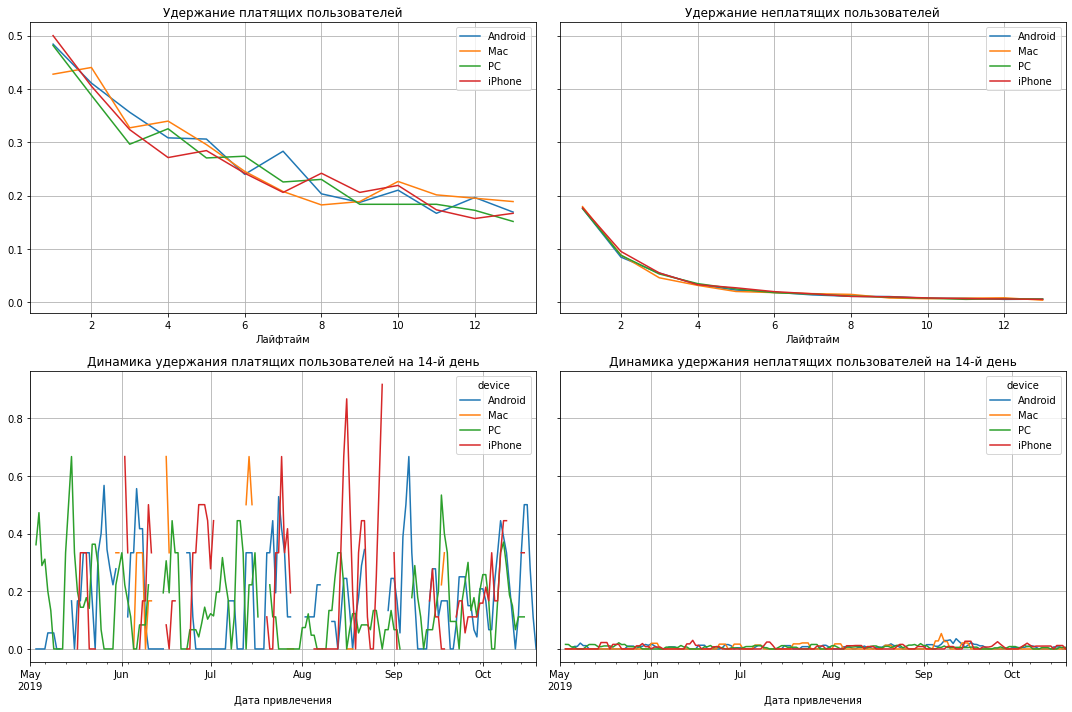

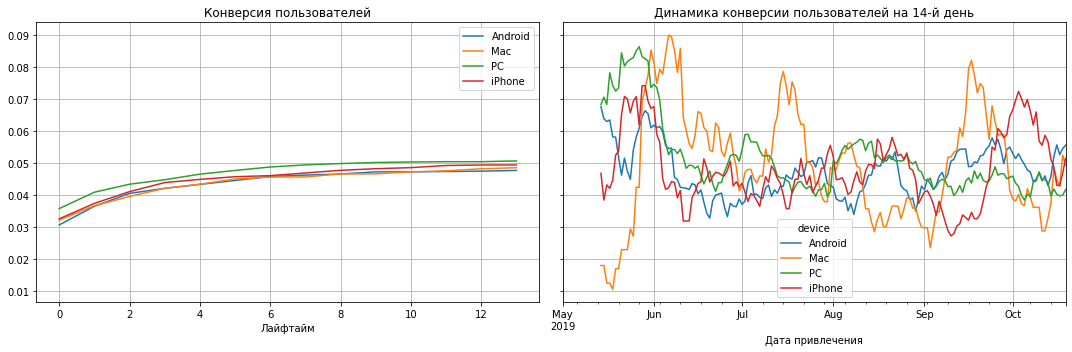

In [63]:
#строим графики для каналов Европы
plot_retention(eu_dev_retent, eu_dev_retent_history, horizon, window=3)
plot_conversion(eu_dev_convers, eu_dev_convers_history, horizon, window=14)

Удержание и конверсия в разрезе устройств в странах Европы тоже в порядке.

In [64]:
#получаем метрики в разрезе устройств и для макрорегиона Европа
usa_dev_ltv_raw, usa_dev_ltv, usa_dev_ltv_history, usa_dev_roi, usa_dev_roi_history = get_ltv(usa_profiles, orders
                                                                                             ,analysis_day
                                                                                       ,horizon,dimensions=['device'])

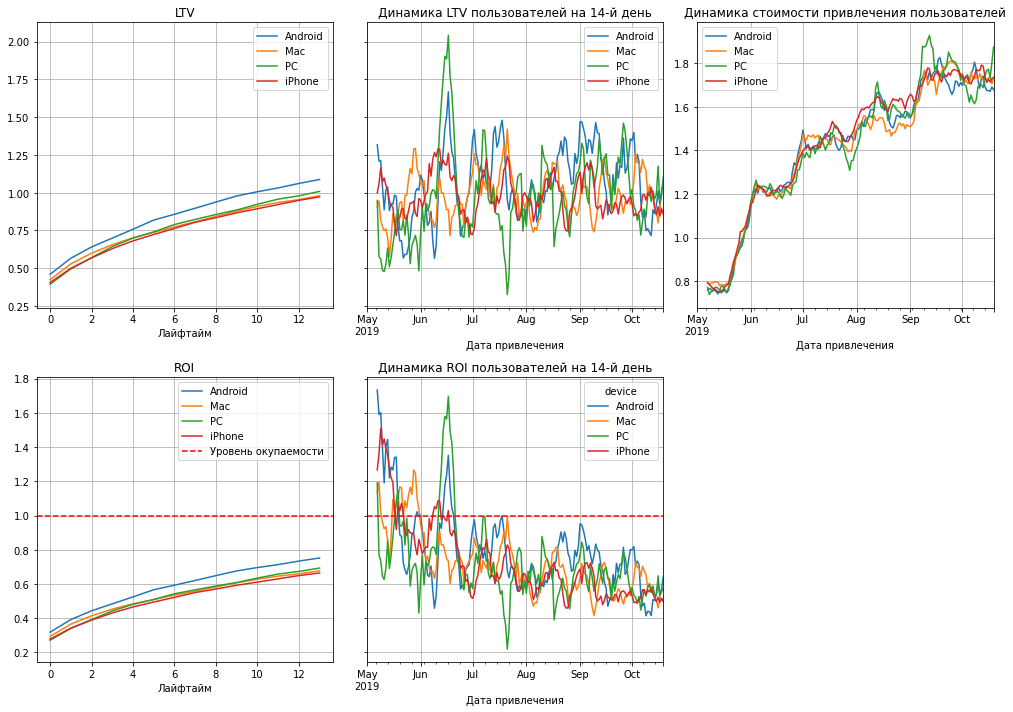

In [65]:
#строим графики в разрезе устройств и для макрорегиона Европа
plot_ltv_roi(usa_dev_ltv, usa_dev_ltv_history, usa_dev_roi, usa_dev_roi_history, horizon, window=7)

В США реклама на всех устройствах не окупается, при том что CAC растет постоянно.

**Вывод**  
Из того что, на всех устройствах в Европе реклама окупается в течение первой недели,  
а в США, наоборот, не окупается в разрезе устройств,  
можно предположить, что окупаемость рекламы не зависит от устройств посещения в данном проекте. 

### Вывод
**Окупается ли реклама в целом?**   
Реклама в целом по проекту не окупается.

**Какие, страны, рекламные каналы, устройства могут снижать окупаемость рекламы?**  
Окупаемость снижает неудачная рекламная кампания в США.  

Каналы, которые не окупаются: в США - FaceBoom, TipTop.  
В странах Европы: AdNonSense.  

Устройства посещения не влияют на окупаемость рекламы в данном проекте.  

**Чем могут быть вызваны проблемы окупаемости?**   
Основная причина - неудачно спланированное распределение бюджета между каналами.  
В США:
- слишком дорогой и постоянно растущий CAC в TipTop, 
- очень низкое удержание клиентов с FaceBoom при довольно дорогой стоимости привлечения,  
- низкая конверсия клиентов с  MediaTornado, YRabbit.  

В странах Европы:  
- очень низкое удержание клиентов с AdNonSense при довольно высокой стоимости рекламы,
- низкая конверсия клиентов с OppleCreativeMedia, LeapBob.

Промежуточные рекомендации для рекламного отдела:  
- перенаправить рекламный бюджет с неокупающихся каналов на каналы с лучшими показателями,
- повысить удержание и конверсию на потенциально выгодных каналах.

## Общий вывод
Общий бюджет на рекламу за изучаемый период - 105 497.3 у.е.  
Около 52% этой суммы потрачено на FaceBoom, около 31% - на TipTop, около 5% - на WahooNetBanner.  

Самые дорогие по средней стоимости привлечения клиенты пришли с TipTop, FaceBoom, AdNonSense.  
Самый низкий средний CAC у OppleCreativeMedia, MediaTornado, YRabbit, LeapBob.  

Средняя стоимость привлечения одного клиента для всего проекта равна 0.75 у.е.  

Больше всего клиентов и платящих из США, на втором и третьем местах - Великобритания и Франция.  
Количественно больше всего платящих пришло (в порядке убывания)  с FaceBoom, TipTop, WahooNetBanner и AdNonSense.  

При рассмотрении пар "Страна - Устройство" в разрезе каналов привлечения платящих, выяснилось, что:  
•	рекламные каналы разные для США и стран Европы, между собой они не пересекаются,  
•	в США это FaceBoom, TipTop, RocketSuperAds, MediaTornado, YRabbit,  
•	в Европе - WahooNetBanner, AdNonSense, LeapBob, OppleCreativeMedia, lambdaMediaAds.  

Рекламные каналы в США и странах Европы сильно различается по долям внутри макрорегионов:  
•	в США доминирут два канала: FaceBoom - 52% суммарно по всем устройствам, TipTop - 27% по всем устройствам,  
•	в Европе два канала, WahooNetBanner и AdNonSense приносят, 23% и 22% соответственно.  

Из того что, на всех устройствах в Европе реклама окупается в течение первой недели,  
а в США, наоборот, не окупается в разрезе устройств,  
можно предположить, что окупаемость рекламы не зависит от устройств посещения в данном проекте.  

**Причины неэффективности привлечения пользователей**  
Основная причина - неудачно спланированное распределение бюджета между каналами.  
В США:
- слишком дорогой и постоянно растущий CAC в TipTop, 
- очень низкое удержание клиентов с FaceBoom при дорогой стоимости привлечения,  
- низкая конверсия клиентов с  MediaTornado, YRabbit.  

В странах Европы:  
- очень низкое удержание клиентов с AdNonSense при довольно высокой стоимости рекламы,
- низкая конверсия клиентов с OppleCreativeMedia, LeapBob, WahooNetBanner.

**Рекомендации для отдела маркетинга по повышению эффективности**  

Стоит рассмотреть вариант балансирования расходов на рекламу - уменьшить в США и увеличить в Европе.

In [66]:
#создание таблицы с  метриками по рекламным каналам США
index = ['TipTop', 'FaceBoom', 'RocketSuperAds', 'YRabbit','MediaTornado']

columns = ['ltv   ','roi   ','День окупаемости','cac   ', 'RR на 14 день', 'CR на 14 день']

data = [['150%','не окуп', '-',  '1-3.5',    '21%',   '9.5%']
        ,['77%','не окуп', '-',   '1.2' ,     '2%',    '12%']   
        ,['90%',  '220%',  '3', '0.5-0.25',  '23%',   '7.2%']
        ,['52%',   '260%', '2', '0.25-0.2',  '10%',   '2.9%']
        ,['54%',   '240%', '2',   '0.2',     '13%',   '2.7%']
       ]
usa_channel = pd.DataFrame(index = index, columns = columns, data = data)

print('Сводная информация о метриках рекламных каналов США')
display(usa_channel)

Сводная информация о метриках рекламных каналов США


,ltv,roi,День окупаемости,cac,RR на 14 день,CR на 14 день
TipTop,150%,не окуп,-,1-3.5,21%,9.5%
FaceBoom,77%,не окуп,-,1.2,2%,12%
RocketSuperAds,90%,220%,3,0.5-0.25,23%,7.2%
YRabbit,52%,260%,2,0.25-0.2,10%,2.9%
MediaTornado,54%,240%,2,0.2,13%,2.7%


В США можно перераспределить бюджет следующим образом:  
максимально сократить расходы на TipTop,  FaceBoom в первую очередь в пользу  
- RocketSuperAds,  
у него очень хорошая и быстрая окупаемость, дешевый CAC, высокое удержание, но следует еще повысить конверсию;  

во вторую очередь в пользу
- YRabbit и MediaTornado,  
у них максимальная и быстрая окупаемость, очень дешевый CAC, хорошее удержание, но следует очень хорошо поднять конверсию.

In [67]:
#создание таблицы с  метриками по рекламным каналам Европы
index = ['WahooNetBanner', 'LeapBob', 'OppleCreativeMedia', 'AdNonSense','lambdaMediaAds']

columns = ['ltv   ','roi   ','День окупаемости','cac   ', 'RR на 14 день', 'CR на 14 день']

data = [['90%',  '150',   '6',  '0.6',      '24%',      '9.5%']
        ,['49%', '225',   '3',   '0.2' ,    '21.9%%',     '3%']   
        ,['48%', '160%',  '5',  '0.27',      '22%',     '2.9%']
        ,['77%', 'не окуп','-', '0.8-1.3',   '2%',     '10.5%']
        ,['175%',  '240%', '2',   '0.6-0.8', '19%',     '10.4%']
       ]
eu_channel = pd.DataFrame(index = index, columns = columns, data = data)

print('Сводная информация о метриках рекламных каналов Европы')
display(eu_channel)

Сводная информация о метриках рекламных каналов Европы


,ltv,roi,День окупаемости,cac,RR на 14 день,CR на 14 день
WahooNetBanner,90%,150,6,0.6,24%,9.5%
LeapBob,49%,225,3,0.2,21.9%%,3%
OppleCreativeMedia,48%,160%,5,0.27,22%,2.9%
AdNonSense,77%,не окуп,-,0.8-1.3,2%,10.5%
lambdaMediaAds,175%,240%,2,0.6-0.8,19%,10.4%


В Европе можно перераспределить бюджет следующим образом:  
максимально сократить расходы на AdNonSense в первую очередь в пользу  
- lambdaMediaAds,  
у него очень максимальная и быстрая окупаемость, средний CAC, высокие удержание и конверсия;  

во вторую очередь в пользу
- LeapBob  
у него высокая и быстрая окупаемость, очень дешевый CAC, высокое удержание, но следует очень хорошо поднять конверсию,  

в третью очередь в пользу
- OppleCreativeMedia  
у него неплохая окупаемость, наступает на 6 день, дешевый CAC, высокое удержание, но следует очень хорошо поднять конверсию.  

